In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import gpxpy
import folium

In [2]:
data_path = Path("data")
gpx_path = data_path / "gpx"

# GPX to CSV

In [3]:

with open(gpx_path/"TerrainPitch.gpx", "r", encoding="utf-8") as gpx_file:
    gpx = gpxpy.parse(gpx_file)

In [4]:
route_info = []
segment = gpx.tracks[0].segments[0]

for point in segment.points:
    route_info.append(
        {
            "time": point.time,
            "latitude": point.latitude,
            "longitude": point.longitude,
            "elevation": point.elevation,
        }
    )


In [5]:
route_df = pd.DataFrame(route_info)
route_df["time_rel"] = (route_df.time - route_df.time.iloc[0]).dt.seconds
route_df.head()
route_df.to_csv(gpx_path / "terrain_pitch.csv",index=False)

# Folium

In [6]:
import folium
import matplotlib.pyplot as plt
from IPython.display import display

plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False


In [7]:
def map_route(points: pd.DataFrame, zoom_level: int = 15):
    route_map = folium.Map(
        location=[points.latitude.mean(), points.longitude.mean()],
        zoom_start=zoom_level,
        tiles="OpenStreetMap",
    )
    route_coords = points[["latitude", "longitude"]].values.tolist()
    folium.PolyLine(route_coords, color="red").add_to(route_map)

    return route_map


In [8]:
map_route(route_df.iloc[500:])


# Distance and elevation

In [9]:
route_df["elevation_diff"] = route_df.elevation.diff()
route_df.head()

time   latitude  longitude  elevation  time_rel  \
0 2023-10-11 22:55:27+00:00  46.777769 -71.274752      137.6         0   
1 2023-10-11 22:55:28+00:00  46.777772 -71.274750      138.0         1   
2 2023-10-11 22:55:29+00:00  46.777775 -71.274750      138.0         2   
3 2023-10-11 22:56:05+00:00  46.778374 -71.275312      138.6        38   
4 2023-10-11 22:56:06+00:00  46.778391 -71.275327      138.6        39   

   elevation_diff  
0             NaN  
1             0.4  
2             0.0  
3             0.6  
4             0.0

In [10]:
import haversine as hs


def haversine_distance(lat: pd.Series, lon: pd.Series) -> pd.Series:
    coords = np.vstack([lat, lon]).T
    distance = hs.haversine_vector(coords[:-1, :], coords[1:, :], hs.Unit.METERS)
    return pd.Series(distance)


route_df["distance"] = haversine_distance(route_df.latitude, route_df.longitude).fillna(0)
route_df.head()


time   latitude  longitude  elevation  time_rel  \
0 2023-10-11 22:55:27+00:00  46.777769 -71.274752      137.6         0   
1 2023-10-11 22:55:28+00:00  46.777772 -71.274750      138.0         1   
2 2023-10-11 22:55:29+00:00  46.777775 -71.274750      138.0         2   
3 2023-10-11 22:56:05+00:00  46.778374 -71.275312      138.6        38   
4 2023-10-11 22:56:06+00:00  46.778391 -71.275327      138.6        39   

   elevation_diff   distance  
0             NaN   0.366707  
1             0.4   0.333585  
2             0.0  79.169618  
3             0.6   2.208618  
4             0.0   1.885707

In [11]:
type(route_df.time_rel.iloc[0])

numpy.int64

In [12]:
route_df["cum_elevation"] = route_df.elevation_diff.cumsum().fillna(0)
route_df["cum_distance"] = route_df.distance.cumsum().fillna(0)
route_df.to_csv(gpx_path / "TerrainPitch_Elevation.csv", index=False)

route_df.head()

time   latitude  longitude  elevation  time_rel  \
0 2023-10-11 22:55:27+00:00  46.777769 -71.274752      137.6         0   
1 2023-10-11 22:55:28+00:00  46.777772 -71.274750      138.0         1   
2 2023-10-11 22:55:29+00:00  46.777775 -71.274750      138.0         2   
3 2023-10-11 22:56:05+00:00  46.778374 -71.275312      138.6        38   
4 2023-10-11 22:56:06+00:00  46.778391 -71.275327      138.6        39   

   elevation_diff   distance  cum_elevation  cum_distance  
0             NaN   0.366707            0.0      0.366707  
1             0.4   0.333585            0.4      0.700293  
2             0.0  79.169618            0.4     79.869911  
3             0.6   2.208618            1.0     82.078529  
4             0.0   1.885707            1.0     83.964236

In [13]:
route_df.tail()

time   latitude  longitude  elevation  time_rel  \
922 2023-10-11 23:11:25+00:00  46.785608 -71.264916      124.0       958   
923 2023-10-11 23:11:26+00:00  46.785615 -71.264906      124.0       959   
924 2023-10-11 23:11:27+00:00  46.785619 -71.264900      124.0       960   
925 2023-10-11 23:11:28+00:00  46.785621 -71.264898      124.0       961   
926 2023-10-11 23:11:29+00:00  46.785624 -71.264900      124.0       962   

     elevation_diff  distance  cum_elevation  cum_distance  
922             0.0  1.088835          -13.6   2603.359685  
923             0.0  0.637593          -13.6   2603.997277  
924             0.0  0.269529          -13.6   2604.266806  
925             0.0  0.366698          -13.6   2604.633504  
926             0.0       NaN          -13.6      0.000000

Text(0, 0.5, 'Elevation (m)')

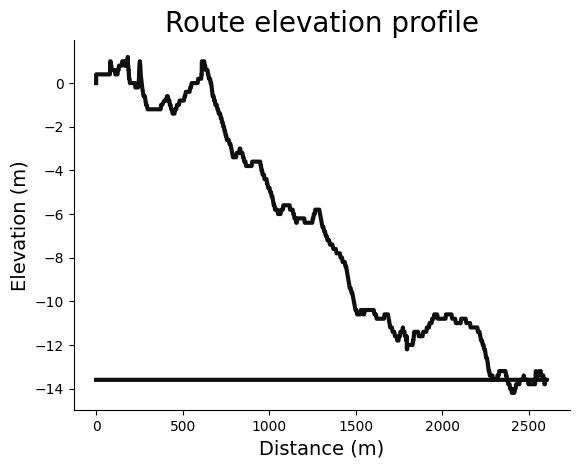

In [14]:
fig, ax = plt.subplots()
ax.plot(route_df.cum_distance, route_df.cum_elevation, color="#101010", lw=3)
ax.set_title("Route elevation profile", size=20)
ax.set_xlabel("Distance (m)", size=14)
ax.set_ylabel("Elevation (m)", size=14)

In [15]:

grade = (route_df.elevation_diff / route_df.distance)
route_df["grade"] = grade.where(grade.abs() < 1, 0).interpolate().fillna(0)
route_df["slope"] = np.degrees(np.arctan(route_df.grade))

Text(0, 0.5, 'Grade (%)')

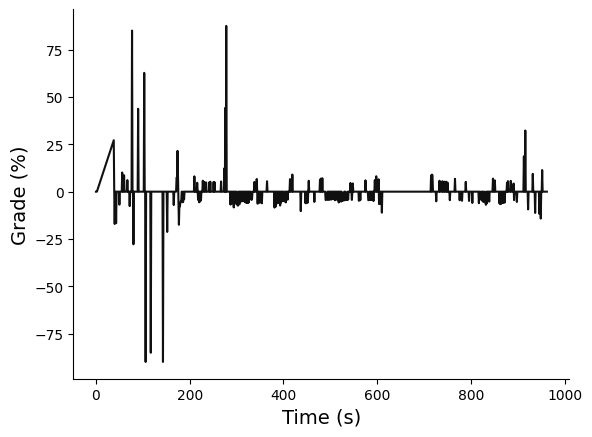

In [16]:
fig, ax = plt.subplots()
ax.plot(route_df.time_rel, 100*route_df.grade, color="#101010")
ax.set_xlabel("Time (s)", size=14)
ax.set_ylabel("Grade (%)", size=14)

In [22]:
def plot_slope(points:pd.DataFrame, min_max=None):
    fig, ax = plt.subplots()
    ax.plot(points.time_rel, points.slope)
    if min_max is not None:
        ax.set_ylim(min_max)
    ax.set_xlabel("Time (s)", size=14)
    ax.set_ylabel("Slope (°)", size=14)

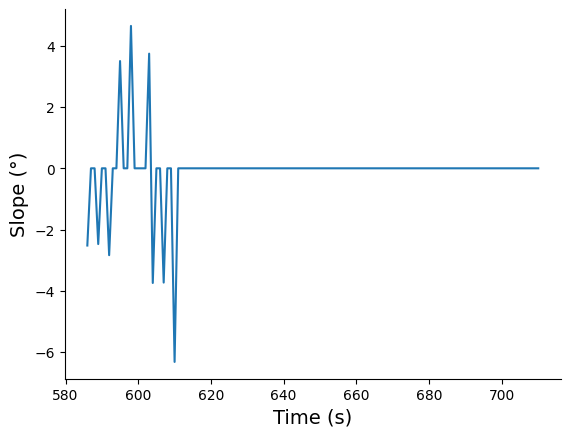

In [70]:
# route_pts = route_df.iloc[4:220]
route_pts = route_df.iloc[550:675]
# plot_slope(route_pts, min_max=(-15, 15))
plot_slope(route_pts)
map_route(route_pts, zoom_level=17)
